In [1]:
import os 
import torch  
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import numpy as np
import matplotlib.pyplot as plt 

from torchvision import transforms
from modules import fpn 
from PIL import Image 

# 0. Prepare helper functions.

In [2]:
class Args:
    def __init__(self):
        pass
    
def collate_eval(batch):
    indice = [b[0] for b in batch]
    image = torch.stack([b[1] for b in batch])
    if batch[0][-1] is not None:
        label = torch.stack([b[2] for b in batch])

        return indice, image, label
    else:
        return indice, image
    
def get_score_histogram(label_trues, label_preds, n_class):
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    
    return hist

def compute_dist(featmap, metric_function, euclidean_train=True):
    # centroids = metric_function.module.weight.data
    centroids = metric_function.weight.data
    if euclidean_train:
        return - (1 - 2*metric_function(featmap)\
                    + (centroids*centroids).sum(dim=1).unsqueeze(0)) # negative l2 squared 
    else:
        return metric_function(featmap)

preprocess = transforms.Compose([transforms.ToTensor(), 
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                      std=[0.229, 0.224, 0.225])])


In [3]:
# args = Args()

# # Model
# args.pretrain = True 
# args.ssl = False 
# args.ssl_dir = False 
# args.arch = 'resnet18'

# # Classifier
# args.in_dim = 128
# args.K = 27

# # Dataloader
# args.data_root = ''

# 1. Load PiCIE.

**NOTE**: Place the COCO version of PiCIE weight at "picie.pkl" 

In [3]:
class Arguments:
    def __init__(self, 
                dist_ = True,
                data_root='../../Data/coco',
                supervised_data_root = '../../Data/coco_supervisedset',
                save_root='results',
                restart_path='',
                seed=1,
                num_workers=6,
                restart=True,
                num_epoch=20,
                repeats=1,
                arch='resnet18',
                pretrain=True,
                res=320,
                res1=320,
                res2=640,
                batch_size_cluster=4,
                batch_size_train=32,
                batch_size_test=8,
                lr=1e-4,
                weight_decay=0,
                momentum=0.9,
                optim_type='Adam',
                num_init_batches=3,
                num_batches=3,
                kmeans_n_iter=30,
                in_dim=128,
                X=80,
                metric_train='cosine',
                metric_test='cosine',
                K_train=27,
                K_test=27,
                no_balance=False,
                mse=False,
                augment=False,
                equiv=False,
                min_scale=0.5,
                stuff=True,
                thing=True,
                jitter=False,
                grey=False,
                blur=False,
                h_flip=False,
                v_flip=False,
                random_crop=False,
                val_type='train',
                version=7,
                fullcoco=False,
                eval_only=False,
                eval_path='results',
                save_model_path='K_train',
                save_eval_path='K_test',
                cityscapes=False,
                faiss_gpu_id=1
                ):
        self.dist_ = dist_
        self.data_root=data_root
        self.supervised_data_root=supervised_data_root
        self.save_root=save_root
        self.restart_path=restart_path
        self.seed=seed
        self.num_workers=num_workers
        self.restart=restart
        self.num_epoch=num_epoch
        self.repeats=repeats
        self.arch=arch
        self.pretrain=pretrain
        self.res=res
        self.res1=res1
        self.res2=res2
        self.batch_size_cluster=batch_size_cluster
        self.batch_size_train=batch_size_train
        self.batch_size_test=batch_size_test
        self.lr=lr
        self.weight_decay=weight_decay
        self.momentum=momentum
        self.optim_type=optim_type
        self.num_init_batches=num_init_batches
        self.num_batches=num_batches
        self.kmeans_n_iter=kmeans_n_iter
        self.in_dim=in_dim
        self.X=X
        self.metric_train=metric_train
        self.metric_test=metric_test
        self.K_train=K_train
        self.K_test=K_test
        self.no_balance=no_balance
        self.mse=mse
        self.augment=augment
        self.equiv=equiv
        self.min_scale=min_scale
        self.stuff=stuff
        self.thing=thing
        self.jitter=jitter
        self.grey=grey
        self.blur=blur
        self.h_flip=h_flip
        self.v_flip=v_flip
        self.random_crop=random_crop
        self.val_type=val_type
        self.cityscapes = cityscapes
        self.version=version
        self.fullcoco=fullcoco
        self.eval_only=eval_only
        self.eval_path=eval_path
        self.save_eval_path = save_eval_path
        self.save_model_path = save_model_path
        self.faiss_gpu_id = faiss_gpu_id


In [4]:
args = Arguments()

In [5]:
picie_load = torch.load('K_train/checkpoint_40.pth.tar', 'cpu')
model_state_dict = {}
classifier_state_dict = {}

for i in picie_load['state_dict'].keys():
    model_state_dict[i[7:]] = picie_load['state_dict'][i]


for i in picie_load['classifier1_state_dict'].keys():
    classifier_state_dict[i[7:]] = picie_load['classifier1_state_dict'][i]


In [6]:
picie_load = torch.load('K_train/checkpoint_40.pth.tar', 'cpu')

model = fpn.PanopticFPN(args)
# model = nn.DataParallel(model) 
model.load_state_dict(model_state_dict)

classifier = nn.Conv2d(args.in_dim, 27, kernel_size=1, stride=1, padding=0, bias=True)
# classifier = nn.DataParallel(classifier)
classifier.load_state_dict(classifier_state_dict)

# Important ! ""
model.eval()
classifier.eval()
model.cuda()
classifier.cuda()

Conv2d(128, 27, kernel_size=(1, 1), stride=(1, 1))

# 2. Cluster the data with pre-trained PiCIE. 

In [7]:
os.environ['LD_LIBRARY_PATH'] = "/home/nova/anaconda3/envs/picie/lib/"

In [8]:
# Run below.
!python prepare_histogram.py 

/home/nova/anaconda3/envs/picie/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:18: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
Batch image size   : torch.Size([64, 3, 320, 320])
Batch label size   : torch.Size([64, 320, 320])
Batch feature size : torch.Size([64, 128, 80, 80])

-Done.


# 3. For each cluster, assign a class label with the majority vote. 

In [9]:
histogram_train = torch.load('results/picie_histogram_coco.pkl')

histogram_train = histogram_train.astype(int)
histogram_train = torch.tensor(histogram_train).topk(1, dim=0)[1].flatten()

map_fn_train = lambda x: histogram_train[x]
mapper_train = np.vectorize(map_fn_train)

# 4. Visualize the predictions. 
Here is an image from the internet. We will visualize how well our model recognizes this image. 

In [10]:
import glob

In [12]:
fig = plt.figure(figsize=(10, 10))
test_set_path = "../../Data/coco_testset/images/*jpg"
result_dest_path =  "test_set_segmentation_results"

for img_path in glob.glob(test_set_path):
    img_raw1 = Image.open(img_path).convert('RGB')
    # img_raw2 = Image.open(img_path).convert('RGB')
    # save_name = os.path.basename(img_path).split(".")[0]
    save_name = os.path.basename(img_path)
    # fig.add_subplot(1, 3, 1)
    # plt.imshow(img_raw1)

    # fig.add_subplot(1, 3, 3)
    # plt.imshow(img_raw2)
    # plt.show()
    # plt.savefig("assets/"+save_name+"_.jpg")
    img1 = preprocess(img_raw1)[None, :]
    out1 = model(img1.cuda())
    out1 = F.normalize(out1, dim=1, p=2)
    prb1 = compute_dist(out1, classifier)
    lbl1 = prb1.topk(1, dim=1)[1]
    lbl1 = lbl1.squeeze(0).squeeze(0)


    # plt.clf()
    # fig = plt.figure(figsize=(10, 10))
    # fig.add_subplot(1, 3, 1)
    plt.imshow(mapper_train(lbl1.cpu()))
    plt.savefig(os.path.join(result_dest_path, save_name))
    plt.clf()

/home/nova/anaconda3/envs/picie/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


<Figure size 1000x1000 with 0 Axes>

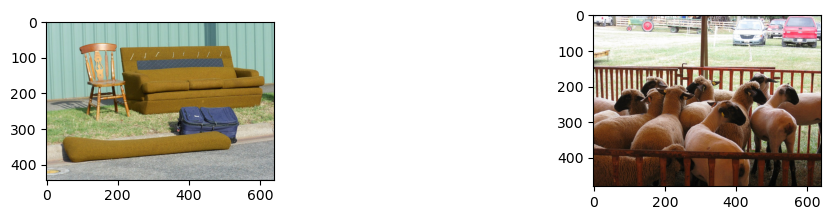

	 Animal						Building


In [61]:
# fig = plt.figure(figsize=(10, 10))

# # img_raw1 = Image.open('assets/000000415073.jpg').convert('RGB')
# # img_raw2 = Image.open('assets/000000498665.jpg').convert('RGB')
# i = 22
# img_raw1 = Image.open(glob("assets/*.jpg")[i])
# img_raw2 = Image.open(glob("assets/*.jpg")[i+1])

# fig.add_subplot(1, 3, 1)
# plt.imshow(img_raw1)

# fig.add_subplot(1, 3, 3)
# plt.imshow(img_raw2)
# # plt.savefig()
# plt.show()
# print('\t Animal\t\t\t\t\t\tBuilding')

In [58]:
img1 = preprocess(img_raw1)[None, :]
out1 = model(img1.cuda())
out1 = F.normalize(out1, dim=1, p=2)
prb1 = compute_dist(out1.cuda(), classifier)
lbl1 = prb1.topk(1, dim=1)[1]
lbl1 = lbl1.squeeze(0).squeeze(0)

img2 = preprocess(img_raw2)[None, :]
out2 = model(img2.cuda())
out2 = F.normalize(out2, dim=1, p=2)
prb2 = compute_dist(out2.cuda(), classifier)
lbl2 = prb2.topk(1, dim=1)[1]
lbl2 = lbl2.squeeze(0).squeeze(0)

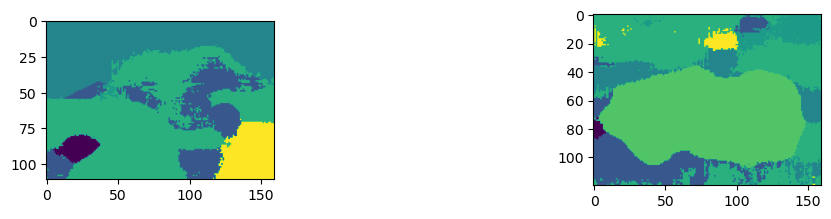

	 Animal						Building


In [59]:
from matplotlib import colors

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 3, 1)
plt.imshow(mapper_train(lbl1.cpu()))

fig.add_subplot(1, 3, 3)
plt.imshow(mapper_train(lbl2.cpu()))
plt.show()
print('\t Animal\t\t\t\t\t\tBuilding')

As seen above, our model is able to group semantically consistent pixeles.

# 5. Visualize the nearest neighbors. 

We further investigate by looking at the nearest neighbors from the validation set of COCO dataset. First, pick a query position on each image. They are *Animal* and *Building* classes, respectively.

In [279]:
i = 8
img_raw1 = Image.open(glob("assets/*.jpg")[i])
img_raw2 = Image.open(glob("assets/*.jpg")[i+1])

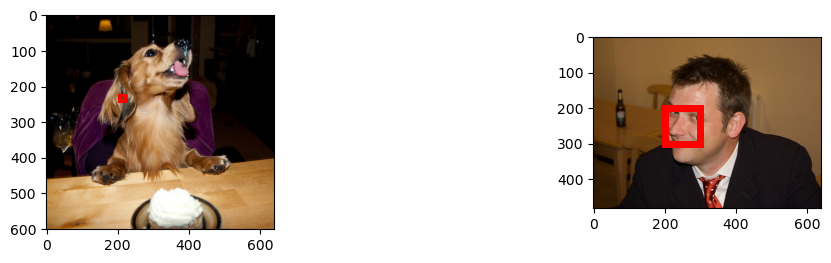

	 Animal						Building


In [282]:
from matplotlib.patches import Rectangle 

fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1, 3, 1)
plt.imshow(img_raw1)
ax = plt.gca()

# w, h
pos1  = (210, 230)
rect1 = Rectangle(pos1, 5, 5, linewidth=5, edgecolor='r', facecolor='none')
ax.add_patch(rect1)

fig.add_subplot(1, 3, 3)
plt.imshow(img_raw2)
ax = plt.gca()

# w, h
pos2  = (200, 200)
rect2 = Rectangle(pos2, 100, 100, linewidth=5, edgecolor='r', facecolor='none')
ax.add_patch(rect2)
plt.show()
print('\t Animal\t\t\t\t\t\tBuilding')

The feature maps are down-sized as below.

In [283]:
print('Image 1 shape       : ', img_raw1.size[::-1])
print('Feature map 1 shape : ', lbl1.cpu().numpy().shape)
print('Image 2 shape       : ', img_raw2.size[::-1])
print('Feature map 2 shape : ', lbl2.cpu().numpy().shape)

Image 1 shape       :  (601, 640)
Feature map 1 shape :  (111, 160)
Image 2 shape       :  (480, 640)
Feature map 2 shape :  (120, 160)


We extract the pixel-level feature for each query and save. 

In [284]:
# h, w
fpos1 = (pos1[1]*55//217, pos1[0]*73//289)
fpos2 = (pos2[1]*55//217, pos2[0]*36//144)

query1 = out1[:, :, fpos1[0], fpos1[1]]
query2 = out2[:, :, fpos2[0], fpos2[1]]
querys = torch.cat([query1, query2])

print('Image 1 query position : ', fpos1)
print('Image 2 query position : ', fpos2)

Image 1 query position :  (58, 53)
Image 2 query position :  (50, 50)


In [285]:
# Save queries.
np.save('querys.npy', querys.detach().cpu().numpy())

Now, we will look for the 5-nearest neighbors for each of these queries. The command below will retrieve the nearest neighbors of each query from the validation set of COCO images.

In [286]:
# os.environ['LD_LIBRARY_PATH'] = "/home/nova/anaconda3/envs/picie/lib/"

In [292]:
# Run below.
!python retrieval.py #--data_root datasets/coco --save_root . --stuff --thing --val_type val --K_test 5 --eval_path "K_train/checkpoint.pth.tar"

/home/nova/anaconda3/envs/picie/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:18: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
-Done.


In [293]:
imglist, loclist = torch.load('results/picie_retrieval_result_coco.pkl')

In [294]:
imglist[1][:5].__len__()

5

In [295]:
loclist[1].__len__()

5





							Animal


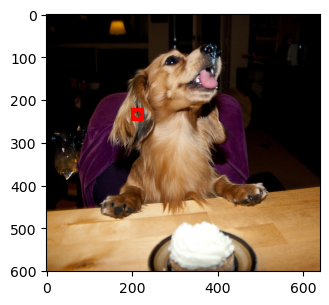

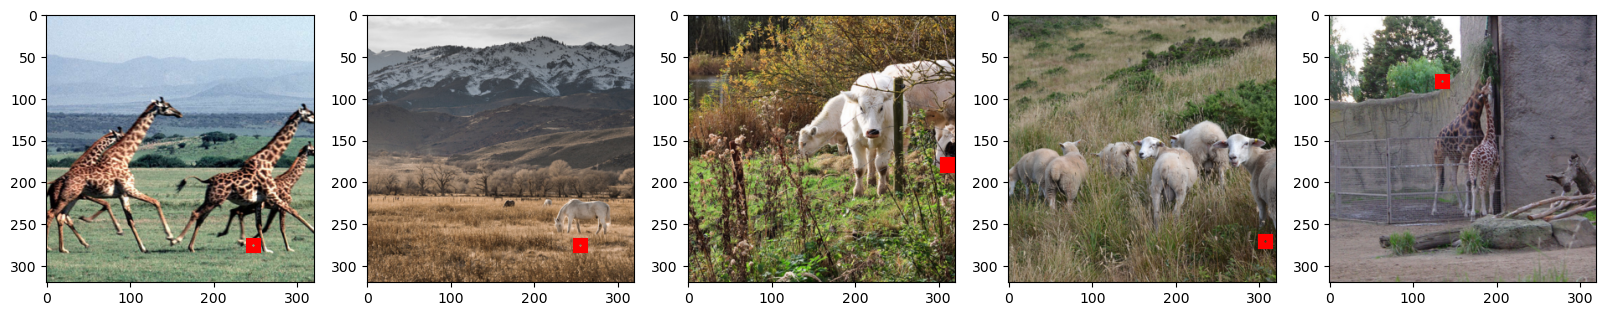





							Building


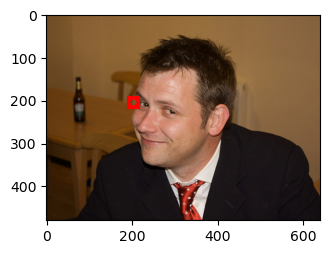

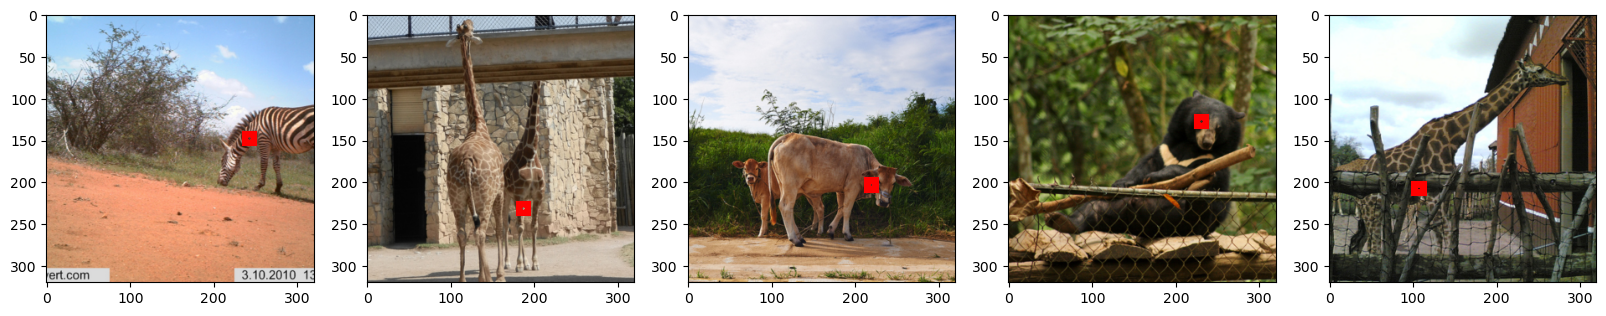

In [296]:
def show_neighbors(img_raw, q_loc, imglist_c, loclist_c):
    fig = plt.figure(figsize=(12, 12))
    fig.add_subplot(1, 3, 2)
    plt.imshow(img_raw)
    ax = plt.gca()

    rect = Rectangle(q_loc, 5, 5, linewidth=8, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

    fig = plt.figure(figsize=(20, 100))
    for i, (img, loc) in enumerate(zip(imglist_c, loclist_c)):
        fig.add_subplot(1, 5, i+1)
        plt.imshow(img)
        ax = plt.gca()

        _, h, w = loc
        rect = Rectangle((4*w, 4*h), 5, 5, linewidth=8, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

print('\n\n\n')
print('\t\t\t\t\t\t\tAnimal')
show_neighbors(img_raw1, pos1, imglist[0], loclist[0])
print('\n\n\n')
print('\t\t\t\t\t\t\tBuilding')
show_neighbors(img_raw2, pos2, imglist[1], loclist[1])